# Package Import

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import pyDOE as doe
import sklearn.gaussian_process.kernels as skl
import time
import seaborn as sns
from tqdm import tqdm
import sys
from joblib import Parallel, delayed
import multiprocessing
import psutil
import os
import shutil
import copy
from matplotlib import gridspec
from scipy.stats import multivariate_normal
import scipy.stats as sps


import pickle as pkl
import tensorflow as tf
import tensorflow_probability as tfp
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import itertools as itr
from sklearn.model_selection import train_test_split

# Utilities

In [2]:
### Variale transformation for unconstrained optimization
def transform_lambda_to_original(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) + 1)
        return phi
    else:
        return np.log(np.exp(phi) + 1)
    
def transform_original_to_lambda(phi):
    if np.any(phi>50):
        phi[np.invert(phi > 50)] = np.log(np.exp(phi[np.invert(phi > 50)]) - 1)
        return phi
    else:
        return np.log(np.exp(phi) - 1)
    
### log transformation of variables in the crime data dataset 
def log_transform(crime_data, center = False, scale = False):
    crime_data.loc[:, crime_data.columns != 'So'] = np.log(crime_data.loc[:, crime_data.columns != 'So'])
    if center:
        crime_data.loc[:, crime_data.columns != 'y'] = crime_data.loc[:, crime_data.columns != 'y'] - crime_data.loc[:, crime_data.columns != 'y'].mean()
    if scale:
        crime_data.loc[:, crime_data.columns != 'y'] = crime_data.loc[:, crime_data.columns != 'y'] / crime_data.loc[:, crime_data.columns != 'y'].std() 
    return crime_data

def power_set_index(n_predictors):
    """Generates a matrix of variable indicators defining the space of 
    all the models
    
    Args:
        n_predictors: Number of predictors to be considered
    Returns:
        A matrix with variable indicators"""
    power_set  = itr.product([0,1], repeat = n_predictors)
    array_index = []
    for i in list(power_set):
        array_index = array_index + [np.array(i)]
    array_index = np.array(array_index)
    ids = np.array([i for i in range(len(array_index))])
    return np.append( np.append(ids[:,None], np.ones(len(array_index))[:, None], axis = 1), array_index, axis = 1)


### Prior computations
def log_pdf_precision_prior(precision):
    return float(np.log(1/precision))

def zg_cov_computation(X_design, model_space, g):
    zg_cov_dictionary = {0: None}
    for i in range(len(model_space) - 1):
        X_model = X_design[:,model_space[i + 1,2:].astype(bool)]    
        zg_cov_dictionary[i + 1] = np.linalg.inv(np.dot(X_model.T, X_model)) * g
    return zg_cov_dictionary

def log_pdf_zg_prior(theta, precision, cov):
    density = sp.stats.multivariate_normal(cov = cov / precision) 
    return density.logpdf(theta)

### Variational families classes
class gaussian_mean_field_family_lambda:
    """Class for a mean field gaussian family of arbitrary dimension with variance parametrization parametrization 
    
    sigma_sq = log(exp(lambda_theta) + 1)
    lambda_theta = log(exp(sigma_sg) - 1)
    
    """
    def __init__(self, mu, lambda_theata, dim):
        """The parameters for the Gaussian mean field family aare passed as a dictionary
        
        Args:
            mu: is a 1-dim Ndarray with the means of independent Gaussian distributions
            lambda_theta: is a 1-dim Ndarray with the transformed variance of independent Gaussian distributions
            dim: Dimension of the family
        """
        
        self.mu = mu
        self.lambda_theta = lambda_theata
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gaussian mean_field variational family
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            sd = np.sqrt(transform_lambda_to_original(self.lambda_theta[i]))
            sample[:, i] = np.random.normal(loc = self.mu[i], scale = sd, size = n_size)     
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gaussian family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            sd = np.sqrt(transform_lambda_to_original(self.lambda_theta[i]))
            density = sp.stats.norm(loc = self.mu[i], scale = sd)
            log_dens = log_dens + density.logpdf(theta[i])     
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t mu and gradient[dim:] are the values of score function w.r.t sigma
        """
        
        gradient_mu = np.zeros(self.dim)
        gradient_lambda = np.zeros(self.dim)
        for i in range(self.dim):
            # score function w.r.t. mean
            gradient_mu[i] = (theta[i] - self.mu[i]) / (np.log(np.exp(self.lambda_theta[i]) + 1))
            # score function w.r.t. lambda
            gradient_lambda[i] = 0.5 * np.exp(self.lambda_theta[i]) * (((theta[i] - self.mu[i]) / np.log(np.exp(self.lambda_theta[i]) + 1)) ** 2 -\
                                                                1 / np.log(np.exp(self.lambda_theta[i]) + 1)) / (np.exp(self.lambda_theta[i]) + 1)
        return gradient_mu, gradient_lambda

class gamma_mean_field_family_lambda:
    """Class for a mean field gamma family of arbitrary dimension, parametrized with mean and variance
    
    
    tau_sq = log(exp(lambda_tau) + 1)
    lambda_tau = log(exp(tau_sq) - 1)
    
    m_sq = log(exp(lambda_m) + 1)
    lambda_m = log(exp(m_sq) - 1)
    
    where alpha corresponds to the mean of the gamma distribution and beta corresponds to the std of the gamma dist
      
      Gamma parametrization:
          
          f(x|alpha, beta) = \frac{beta ^ alpha}{Gamma(alpha)} * x ^{alpha - 1} * \exp{- beta * x}
          
          E(X) = alpha / beta
          Var(X) = alpha / (beta^2)
          
    """
    
    def __init__(self, lambda_m, lambda_tau, dim):
        """The parameters for the gamma mean field family are passed as a dictionary
        
        Args:
            param: A dictionaray containing two entries with arrays of dimension (dim,)
                 - param["alpha"] is a 1-dim Ndarray with the mean paramteres of the independent Gamma distribution
                 - param["beta"] is a 1-dim Ndarray with the stds of independent Gamma distributions
                 - param["a"] see parametrization
            dim: Dimension of the family
        """
        
        self.lambda_m = lambda_m
        self.lambda_tau = lambda_tau
        self.dim = dim
        
    def sample(self, n_size):
        """Samples from the gamma mean field variational family
        
        Note: np.random.gamma has parametrization with shape = alpha, scale = 1 / beta
        
        Args:
            n_size: the number of samples to be generated
        Returns:
            samle: 2 dimensional NDarray where each row is a single sample from the variational family
        """
        
        sample = np.zeros((n_size, self.dim))
        for i in range(self.dim):
            mu = transform_lambda_to_original(self.lambda_m[i])
            sigma_sq = transform_lambda_to_original(self.lambda_tau[i])
            alpha = float((mu ** 2 )/ sigma_sq)
            beta = float(mu/ sigma_sq)
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            samples = tfdGamma.sample(n_size)
            sample[:, i] = samples.numpy()
        return sample
    
    def log_pdf(self, theta):
        """Calculates the value of log density of the mean field gamma family at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log density will be evaluated
        Returns:
            log_dens: The value of log density at theta
        """
        
        log_dens = 0
        for i in range(self.dim):
            mu = transform_lambda_to_original(self.lambda_m[i])
            sigma_sq = transform_lambda_to_original(self.lambda_tau[i])
            alpha = float((mu ** 2 )/ sigma_sq)
            beta = float(mu / sigma_sq)
            tfd = tfp.distributions
            tfdGamma = tfd.Gamma(concentration=alpha, rate=beta)
            log_dens = log_dens + float(tfdGamma.log_prob(theta[i]))
        return log_dens
    
    def grad_log_pdf(self, theta):
        """Calculates the value of score function at theta
        
        Args:
            theta: 1-dim Ndarray of theta values at which the log gradient will be evaluated
        Returns:
            gradient: 1-dim Ndarray of len(2 * dim) where gradient[:dim] are the values of score function
                    w.r.t alpha and gradient[dim:] are the values of score function w.r.t beta
        """
        
        gradient_lambda_m = np.zeros(self.dim)
        gradient_lambda_tau = np.zeros(self.dim)
        for i in range(self.dim):    
            l_m_factor = - np.exp(self.lambda_m[i]) / ((np.log(np.exp(self.lambda_tau[i]) + 1)) * (np.exp(self.lambda_m[i]) + 1))
            gradient_lambda_m[i] = l_m_factor * (theta[i] + np.log(np.exp(self.lambda_m[i]) + 1) * ( - 1 - 2 * np.log(np.log(np.exp(self.lambda_m[i]) + 1)) + \
                                                                                                   2 * np.log(np.log(np.exp(self.lambda_tau[i]) + 1)) + \
                                                                                                   2 * sp.special.digamma((np.log(np.exp(self.lambda_m[i]) + 1) ** 2)/ np.log(np.exp(self.lambda_tau[i]) + 1)) - \
                                                                                                   2 * np.log(theta[i]) ))
            
            # score function w.r.t. lambda_tau
            l_tau_factor = np.exp(self.lambda_tau[i]) * np.log(np.exp(self.lambda_m[i]) + 1) / ((np.log(np.exp(self.lambda_tau[i]) + 1) ** 2) * (np.exp(self.lambda_tau[i]) + 1))
            gradient_lambda_tau[i] = l_tau_factor * (theta[i] + np.log(np.exp(self.lambda_m[i]) + 1) * ( - 1 - np.log(np.log(np.exp(self.lambda_m[i]) + 1)) + \
                                                                                                   np.log(np.log(np.exp(self.lambda_tau[i]) + 1)) + \
                                                                                                   sp.special.digamma((np.log(np.exp(self.lambda_m[i]) + 1) ** 2)/ np.log(np.exp(self.lambda_tau[i]) + 1)) - \
                                                                                                   np.log(theta[i]) ))
        return gradient_lambda_m, gradient_lambda_tau
    

def regression_log_likelihood(Y, X, theta, precision):
    """Computes log-likelihood of a standard regression model """
    n = len(X)
    means = np.dot(X, theta)
    log_likelihood = 0.5 * n * (np.log(precision) -  np.log(2 * np.pi)) - 0.5 * precision * np.sum((Y - means) ** 2)
    return float(log_likelihood)

def ADAgrad(prev, current, rho):
    """The ADAgrad adaptive learning rate
    
    Args:
        prev: The previous value of the sum of the squared gadients
        current: Current value of the ELBO gradient
        rho: Innitial step size
    Returns:
        step: An updation of the vaiational parameter
        G_T: Updated sum of squared gradients
        """
    G_T = prev  + current ** 2
    step = rho / np.sqrt(G_T + 10 ** (-6))
    #step = rho / np.sqrt(prev + 10 ** (-6))
    return step, G_T


def input_locations(d_input, n_input, lims, criterion = "c"): #Works for general case
    """Simulation inputs generator
    
    The function generates inputs for model/observations according to latin hypercube design/uniform
    within given range and dimension of inputs
    
    Args:
        d_input: The dimension of inputs to be generated
        n_input: The number of inputs
        lims: Ndarray with the range of inputs for each variable , each row is limits for each var
        criterion: "uniform" for unifomr "c", "m" for different version of latin hypercube design
        
    Returns:
        inputs: n_input * d_input Ndarray with generated input points.
    """
    if criterion == "uniform":
        inputs = []
        for i in range(d_input):
            inputs = inputs + [np.linspace(lims[i, 0], lims[i, 1], int(n_input ** (1 / d_input)))]
            
        grid_list = np.meshgrid(*inputs)
        
        inputs = np.zeros((n_input, d_input))
        for i in range(d_input):
            inputs[:,i] = grid_list[i].flatten()        
        
    else:
        # Data generation
        inputs = doe.lhs(d_input, samples = n_input, criterion = criterion)

        # Transformation for the interval
        for i in range(d_input):
            inputs[:,i] = inputs[:,i] * (lims[i,1] - lims[i, 0]) + lims[i, 0]

    return inputs


def normal_density(theta,mu, sd):
    density = sp.stats.norm(loc = mu, scale = sd)
    pdf = density.pdf(theta)     
    return pdf


# Posterior sampling
def BBVBMA_predictions(post_means, post_std, post_psi_m, post_psi_t, weights,
                       model_space, k, n_sample, data_new, vars_test):
    
    post_samples = {"BMA": np.zeros((data_new.shape[0], n_sample))}
    for i in range(len(model_space)):
        post_samples[str(i)] = np.zeros((data_new.shape[0], n_sample))

    for i in tqdm(range(n_sample)):

            r = np.random.uniform()
            model_i = 0 
            u_bound = weights[model_i]

            while r > u_bound:
                model_i = model_i + 1
                u_bound = u_bound + weights[model_i]
            #print("r: " + str(r))
            #print("M" + str(model_i))
            #print(model_i)
            precision_variational = gamma_mean_field_family_lambda(lambda_m = np.array([post_psi_m [model_space[model_i,0]]]),
                                                                   lambda_tau = np.array([post_psi_t[model_space[model_i,0]]]),
                                                                   dim = 1)
            precision_sample = precision_variational.sample(1).flatten()
            #print(precision_sample)
            post_mean_pred = np.ones(len(data_new)) * post_means[model_space[model_i,0], 0]
            for j in range(k):
                if model_space[model_i,2:][j] == 1:
                    post_mean_pred = post_mean_pred + np.array(data_new[vars_test[j]]) * np.random.normal(loc = post_means[model_space[model_i,0], j+1], scale = post_std[model_space[model_i,0], j+1])
            post_samples["BMA"][:,i] = np.random.normal(loc = post_mean_pred, scale = np.ones(len(data_new)) * np.sqrt(1 / precision_sample))
            #print(post_mean_pred)

            for model_i in range(len(model_space)):
                precision_variational = gamma_mean_field_family_lambda(lambda_m = np.array([post_psi_m [model_space[model_i,0]]]),
                                                                   lambda_tau = np.array([post_psi_t[model_space[model_i,0]]]),
                                                                   dim = 1)
                precision_sample = precision_variational.sample(1).flatten()
                #print(precision_sample)
                post_mean_pred = np.ones(len(data_new)) * post_means[model_space[model_i,0], 0]
                for j in range(k):
                    #print(j)
                    if model_space[model_i,2:][j] == 1:
                        #print(vars_test[j])
                        post_mean_pred = post_mean_pred + np.array(data_new[vars_test[j]]) * np.random.normal(loc = post_means[model_space[model_i,0], j+1], scale = post_std[model_space[model_i,0], j+1])
                post_samples[str(model_i)][:,i] = np.random.normal(loc = post_mean_pred, scale = np.ones(len(data_new)) * np.sqrt(1 / precision_sample))
                #print(post_mean_pred)
    return post_samples

# Crime data loading and pre-processing

In [6]:
### Loading the crime data
UScrime = pd.read_csv("UScrime.csv", index_col= 0) # Full dataset of crime data
# UScrime = pd.read_csv("UScrime_train.csv", index_col= 0) # Training dataset of crime data 

UScrime_log = log_transform(UScrime.copy(), center= False, scale = False)
UScrime_log_center = log_transform(UScrime.copy(), center= True, scale = False)
UScrime_log_center_scale = log_transform(UScrime.copy(), center= True, scale = True)

### Choices of the size of the variable set (and which variables)
vars_n = "2"
if vars_n == "4":
    vars_test = ["M", "So", "Ed", "Prob"]
elif vars_n == "3":
    vars_test = ["M", "So", "Prob"]
elif vars_n == "2":
    vars_test = ["M", "Prob"]
    
### Full model design matrix and variable tranformation choice
design_type = "logC"
if design_type == "logC":
    X_design = UScrime_log_center.loc[:, vars_test].values
elif design_type == "log":
    X_design = UScrime_log.loc[:, vars_test].values
    
X_design_intercept = np.append(np.ones((len(X_design),1)), X_design, axis = 1)
Y = UScrime_log_center.loc[:, "y"].values

# Model space indicator matrix geneation
K = len(vars_test) # Number of predictors
model_space = power_set_index(K).astype(int)

# BBVBMA Stage

In [7]:
### Creating variational parameters matrices
# Thetas
q_theta_m = np.zeros((len(model_space), K + 1))
q_theta_lambda_s = transform_original_to_lambda(np.ones((len(model_space), K + 1)) * 0.09)
# Precisions
q_psi_lambda_m = np.ones(len(model_space))
q_psi_lambda_t = np.ones(len(model_space))
# Model space q
q_A = np.ones(len(model_space)) / len(model_space)
pi_A = np.ones(len(model_space)) / len(model_space)

# Zelner prior covariance matric precomputation
g = len(X_design)
zg_cov_dictionary = zg_cov_computation(X_design, model_space, g)
zg_cov_dictionary[0] = np.std(Y) ** 2

### Innitialization of variational parameters
# Precisions
q_psi_lambda_m = q_psi_lambda_m * transform_original_to_lambda(1 / ((np.std(Y) ) ** 2))
q_psi_lambda_t = q_psi_lambda_t * transform_original_to_lambda(np.std(Y) ** 2)

### VI optimization innitiation
n_VI = 100# number of steps in VI
S_G = 130 # Sample size for MC approximation of G
rho = 0.0001 # Innitial Step size

folder = "Vars_" + vars_n + "_design_" + design_type + "_nVI_" + str(n_VI) + "_S_" + str(S_G) + "_rho_" + str(rho)

q_A_array = np.zeros((n_VI, len(model_space)))
q_theta_m_array = np.zeros((n_VI, len(model_space), K + 1))
q_theta_lambda_s_array = np.ones((n_VI, len(model_space), K + 1))
# Precisions
q_psi_lambda_m_array = np.ones((n_VI, len(model_space)))
q_psi_lambda_t_array = np.ones((n_VI, len(model_space)))
ELBO = np.zeros((n_VI, len(model_space)))

### Folder to save results
if not os.path.exists(folder):
    os.makedirs(folder)
else:
    shutil.rmtree(folder)           #removes all the subdirectories!
    os.makedirs(folder)
    
### ELBO optimization via SGA
time_counter = np.array(time.monotonic())
tf.random.set_seed(123)
np.random.seed(123)
for i in tqdm(range(n_VI)): # outer loop for stochastic gradient
    q_A_star = np.ones(len(model_space)) / len(model_space)

    for model in model_space: # cycling through all the possible models in the model space

        # Generating sample from variational distribution
        precision_variational = gamma_mean_field_family_lambda(lambda_m = np.array([q_psi_lambda_m[model[0]]]),
                                                               lambda_tau = np.array([q_psi_lambda_t[model[0]]]),
                                                               dim = 1)
        precision_sample = precision_variational.sample(S_G)

        theta_variational = gaussian_mean_field_family_lambda(mu = q_theta_m[model[0], model[1:].astype(bool)],
                                                              lambda_theata = q_theta_lambda_s[model[0], model[1:].astype(bool)],
                                                              dim = np.sum(model[1:]))
        theta_sample = theta_variational.sample(S_G)

        L_A_hat = 0
        G_mu = np.zeros(np.sum(model[1:]))
        G_lambda = np.zeros(np.sum(model[1:]))
        G_lambda_mu = np.zeros(1)
        G_lambda_tau = np.zeros(1)
        for s in range(S_G):
            # Data likelihood comp
            log_L = regression_log_likelihood(Y, X = X_design_intercept[:,  model[1:].astype(bool)],
                                              theta = theta_sample[s,:],
                                              precision = precision_sample[s,:])
            # Variational log likelihood comp
            log_q = precision_variational.log_pdf(precision_sample[s,:]) + theta_variational.log_pdf(theta_sample[s,:])

            # Prior log likelihood comp
            log_p = log_pdf_precision_prior(precision_sample[s,:])
            if model[0] > 0:
                log_p = log_p + log_pdf_zg_prior(theta = theta_sample[s,1:],
                                                 precision = precision_sample[s,:],
                                                 cov = zg_cov_dictionary[model[0]])
            
            L_component = log_L + log_p - log_q
            L_A_hat = L_A_hat + L_component / S_G


            # Grdients computation
            gradient_mu, gradient_lambda = theta_variational.grad_log_pdf(theta_sample[s,:])
            gradient_lambda_m, gradient_lambda_tau = precision_variational.grad_log_pdf(precision_sample[s,:])

            G_mu = G_mu  + gradient_mu * L_component / S_G
            G_lambda = G_lambda  + gradient_lambda * L_component / S_G
            G_lambda_mu = G_lambda_mu + gradient_lambda_m * L_component / S_G
            G_lambda_tau = G_lambda_tau + gradient_lambda_tau * L_component / S_G
            
        
        # q_A update
        ELBO[i, model[0]] = L_A_hat
        q_A_star[model[0]] = np.exp(L_A_hat + np.log(pi_A[model[0]]))


        # q_theta update
        # Edit the following if conditions if you want the posterior model weights to be computed
        # after the first (n_VI * x / 8) iterations of the optimizer
        if i > (n_VI * 8 / 8):
            q_theta_m[model[0], model[1:].astype(bool)] = q_theta_m[model[0], model[1:].astype(bool)] + rho * q_A[model[0]] * G_mu
            q_theta_lambda_s[model[0], model[1:].astype(bool)] = q_theta_lambda_s[model[0], model[1:].astype(bool)] + rho * q_A[model[0]] * G_lambda

            q_psi_lambda_m[model[0]] = q_psi_lambda_m[model[0]] + rho * q_A[model[0]] * G_lambda_mu
            q_psi_lambda_t[model[0]] = q_psi_lambda_t[model[0]] + rho * q_A[model[0]] * G_lambda_tau
        else:
            q_theta_m[model[0], model[1:].astype(bool)] = q_theta_m[model[0], model[1:].astype(bool)] + rho * G_mu
            q_theta_lambda_s[model[0], model[1:].astype(bool)] = q_theta_lambda_s[model[0], model[1:].astype(bool)] + rho * G_lambda

            q_psi_lambda_m[model[0]] = q_psi_lambda_m[model[0]] + 1 * rho * G_lambda_mu
            q_psi_lambda_t[model[0]] = q_psi_lambda_t[model[0]] + 1 * rho * G_lambda_tau
            
        
    # Updates of progression
    q_theta_m_array[i,:,:] = q_theta_m.copy()
    q_theta_lambda_s_array[i,:,:] = q_theta_lambda_s.copy()
    q_psi_lambda_m_array[i,:] = q_psi_lambda_m.copy()
    q_psi_lambda_t_array [i,:]= q_psi_lambda_t.copy()

    #Averaged version
    if i > (n_VI * 8 / 8):
        #Averaged version
        q_A = q_A_star.copy() / np.sum(q_A_star)
    q_A_array[i, :] = q_A.copy()
    time_counter = np.append(time_counter, time.monotonic())

    if (i % 20) == 19:
        np.save(os.getcwd() + "/" + folder + "/" + "theta_m", q_theta_m_array)
        np.save(os.getcwd() + "/" + folder + "/" + "theta_lambda", q_theta_lambda_s_array)
        np.save(os.getcwd() + "/" + folder + "/" + "psi_lambda_m", q_psi_lambda_m_array)
        np.save(os.getcwd() + "/" + folder + "/" + "psi_lambda_t", q_psi_lambda_t_array)
        np.save(os.getcwd() + "/" + folder + "/" + "q_A", q_A_array)
        np.save(os.getcwd() + "/" + folder + "/" + "ELBO", ELBO)
        np.save(os.getcwd() + "/" + folder + "/" + "time", time_counter)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:41<00:00,  2.43it/s]


## Results plot

### ELBO

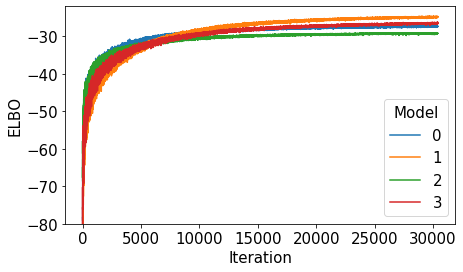

In [10]:
### Loading pre-computed results
vars_n = "2"
design_type = "logC"
n_VI = 50000
S_G = 130
rho = 0.0001
folder = "Vars_" + vars_n + "_design_" + design_type + "_nVI_" + str(n_VI) + "_S_" + str(S_G) + "_rho_" + str(rho)
ELBO = np.load("Crime_Results/Full/" + folder + "/ELBO.npy")
q_A_array = np.load("Crime_Results/Full/" + folder + "/q_A.npy")
q_theta_m_array = np.load("Crime_Results/Full/" + folder + "/theta_m.npy")
q_theta_lambda_array = np.load("Crime_Results/Full/" + folder + "/theta_lambda.npy")

### Plotting
fig = plt.figure(figsize=(7, 4))
plt.rcParams.update({'font.size': 15})
gs = gridspec.GridSpec(1, 1)

n_print_ELBO = 30400
n_print = 200
n_post = 1000

ax = plt.subplot(gs[0])
ax.plot(ELBO[(np.sum(ELBO.any(axis = 1)) - n_print_ELBO):np.sum(ELBO.any(axis = 1)),:])
ax.set_ylim([-80,-22])
ax.set_xlabel('Iteration')
ax.set_ylabel('ELBO')
ax.legend(["0", "1", "2", "3"], title='Model')
plt.show()

### Parameters

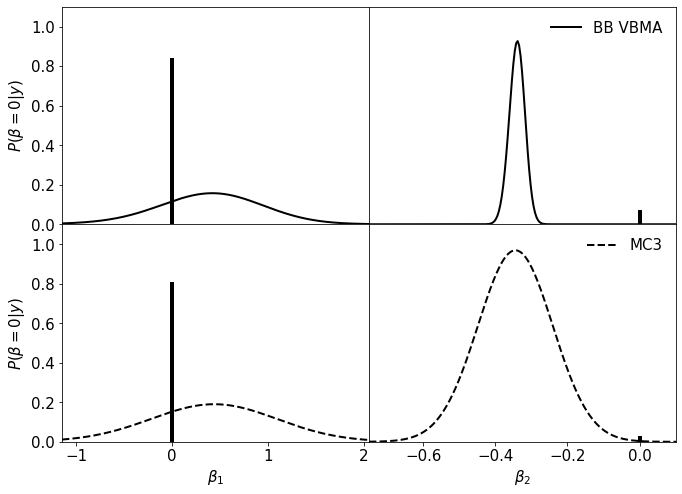

In [14]:
### Loading pre-computed results
vars_n = "2"
design_type = "logC"
n_VI = 50000
S_G = 130
rho = 0.0001
folder = "Vars_" + vars_n + "_design_" + design_type + "_nVI_" + str(n_VI) + "_S_" + str(S_G) + "_rho_" + str(rho)
ELBO = np.load("Crime_Results/Full/" + folder + "/ELBO.npy")
q_A_array = np.load("Crime_Results/Full/" + folder + "/q_A.npy")
q_theta_m_array = np.load("Crime_Results/Full/" + folder + "/theta_m.npy")
q_theta_lambda_array = np.load("Crime_Results/Full/" + folder + "/theta_lambda.npy")

### Plotter
# Computing model probabilities
model_space = power_set_index(int(vars_n)).astype(int)
range_plot = [-10,10]
n_points = 5000
x = np.linspace(range_plot[0], range_plot[1], num = n_points)


n_post = 1000
mod_post = np.exp(ELBO[(np.sum(ELBO.any(axis = 1)) - n_post):np.sum(ELBO.any(axis = 1)),:]) / np.sum(np.exp(ELBO[(np.sum(ELBO.any(axis = 1)) - n_post):np.sum(ELBO.any(axis = 1)),:]), axis = 1)[:,None]
Q = np.mean(mod_post[-n_post:,:], axis = 0)

post_means = q_theta_m_array[(np.sum(ELBO.any(axis = 1)) - 1),:,:]
post_std = transform_lambda_to_original(q_theta_lambda_array[(np.sum(ELBO.any(axis = 1)) - 1),:,:])

beta_1 = np.zeros(n_points)
beta_2 = np.zeros(n_points)

beta_1_p = 0
beta_2_p = 0

for i in model_space:
    if i[2] == 1:
        beta_1 = beta_1 + normal_density(x, post_means[i[0],1], post_std[i[0],1]) * Q[i[0]]
        beta_1_p += Q[i[0]]
    
    if i[3] == 1:
        beta_2 = beta_2 + normal_density(x, post_means[i[0],2], post_std[i[0],2]) * Q[i[0]]
        beta_2_p += Q[i[0]]
        
# Plot settings
lw_v = 4
lw_dens = 2
dens_col = "black"
line_col = "black"



fig = plt.figure(figsize=(11, 8))
plt.rcParams.update({'font.size': 15})
gs = gridspec.GridSpec(2, 2, hspace = 0.001, wspace = 0.001)

# BBVBMA results
# Beta 1
# Rescaling
beta_1 = (beta_1 / max(beta_1)) * (beta_1_p)
ax = plt.subplot(gs[0])
ax.plot(x,beta_1, lw = lw_dens, color = dens_col, label = "BB VBMA")
ax.vlines(x = 0, ymin = 0, ymax = (1 - beta_1_p), lw = lw_v, color = line_col)
ax.set_ylim([0,1.1])
ax.set_xlim([-1.15,2.05])
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$P(\beta = 0|y)$")

# Beta 2
# Rescaling
beta_2 = (beta_2 / max(beta_2)) * (beta_2_p)
ax = plt.subplot(gs[1])
ax.plot(x,beta_2, lw = lw_dens, color = dens_col, label = "BB VBMA")
ax.vlines(x = 0, ymin = 0, ymax = (1 - beta_2_p), lw = lw_v, color = line_col)
ax.set_ylim([0,1.1])
ax.set_xlim([-0.75,0.1])
ax.set_xlabel(r"$\beta_2$")
ax.set_yticks([])
ax.legend(frameon=False)

# MCMC results
beta_1 = 0.1850000 * normal_density(x, 0.4462741, 0.6533355) + 0.004400000 * normal_density(x, -0.2591021, 0.6868496)
beta_2 = 0.779700 * normal_density(x, -0.3403755, 0.1022352) + 0.1850000 * normal_density(x, -0.3642613, 0.1086179)

beta_1_p = 0.19027
beta_2_p = 0.96903 

# Beta 1
# Rescaling
beta_1 = (beta_1 / max(beta_1)) * (beta_1_p)
ax = plt.subplot(gs[2])
ax.plot(x,beta_1, lw = lw_dens, color = dens_col, linestyle = '--')
ax.vlines(x = 0, ymin = 0, ymax = (1 - beta_1_p), lw = lw_v, color = line_col)
ax.set_ylim([0,1.1])
ax.set_xlim([-1.15,2.05])
ax.set_xlabel(r"$\beta_1$")
ax.set_ylabel(r"$P(\beta = 0|y)$")

# Beta 2
# Rescaling
beta_2 = (beta_2 / max(beta_2)) * (beta_2_p)
ax = plt.subplot(gs[3])
ax.plot(x,beta_2, lw = lw_dens, color = dens_col, linestyle = '--', label = "MC3")
ax.vlines(x = 0, ymin = 0, ymax = (1 - beta_2_p), lw = lw_v, color = line_col)
ax.set_ylim([0,1.1])
ax.set_xlim([-0.75,0.1])
ax.set_xlabel(r"$\beta_2$")
ax.set_yticks([])
ax.legend(frameon=False)
plt.show()

## Predictions

In [15]:
### Loading precomputed data for the input
design_type = "logC"
vars_n = "2"
n_VI = 50000
S_G = 130
rho = 0.001
folder = "Vars_" + vars_n + "_design_" + design_type + "_nVI_" + str(n_VI) + "_S_" + str(S_G) + "_rho_" + str(rho)
ELBO = np.load("Crime_Results/Train/" + folder + "/ELBO.npy")
q_A_array = np.load("Crime_Results/Train/" + folder + "/q_A.npy")
q_theta_m_array = np.load("Crime_Results/Train/" + folder + "/theta_m.npy")
q_theta_lambda_array = np.load("Crime_Results/Train/" + folder + "/theta_lambda.npy")
q_psi_m_array = np.load("Crime_Results/Train/" + folder + "/psi_lambda_m.npy")
q_psi_t_array = np.load("Crime_Results/Train/" + folder + "/psi_lambda_t.npy")


# Inputs for model betas
post_means = q_theta_m_array[(np.sum(ELBO.any(axis = 1)) - 1),:,:]
post_std = transform_lambda_to_original(q_theta_lambda_array[(np.sum(ELBO.any(axis = 1)) - 1),:,:])

# Posterior precision
post_psi_m = q_psi_m_array[(np.sum(ELBO.any(axis = 1)) - 1),:]
post_psi_t = q_psi_t_array[(np.sum(ELBO.any(axis = 1)) - 1),:]

# Model weights
# Computed as the average over the last 1000 iterations of ELBO
n_post = 1000
mod_post = np.exp(ELBO[(np.sum(ELBO.any(axis = 1)) - n_post):np.sum(ELBO.any(axis = 1)),:]) / np.sum(np.exp(ELBO[(np.sum(ELBO.any(axis = 1)) - n_post):np.sum(ELBO.any(axis = 1)),:]), axis = 1)[:,None]
Q = np.mean(mod_post[-n_post:,:], axis = 0)

# Testing data load and transformation
UScrime_new = pd.read_csv("UScrime_test.csv", index_col= 0)
data_new = log_transform(UScrime_new .copy(), center= True, scale = False)

#### Seting function paramteres
if vars_n == "4":
    vars_test = ["M", "So", "Ed", "Prob"]
elif vars_n == "3":
    vars_test = ["M", "So", "Prob"]
elif vars_n == "2":
    vars_test = ["M", "Prob"]

### BMA Sampler
k = len(vars_test) # Number of predictors
model_space = power_set_index(k).astype(int)
n_sample = 10000
weights = Q

##### End of preset, now actual function code
post_samples = BBVBMA_predictions(post_means, post_std, post_psi_m, post_psi_t, weights,
                       model_space, k, n_sample, data_new, vars_test)



100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:54<00:00, 182.38it/s]


In [16]:
### Credible interval and predictive coverage
alpha = 0.1

credible_int = {"BMA": np.zeros((data_new.shape[0], 2))}
for i in range(len(model_space)):
    credible_int[str(i)] = np.zeros((data_new.shape[0], 2))

credible_int["BMA"][:,0] = np.quantile(post_samples["BMA"], alpha / 2, axis =1)
credible_int["BMA"][:,1] = np.quantile(post_samples["BMA"],1 - alpha / 2, axis =1)

for i in range(len(model_space)):
    credible_int[str(i)][:,0] = np.quantile(post_samples[str(i)], alpha / 2, axis =1)
    credible_int[str(i)][:,1] = np.quantile(post_samples[str(i)],1 - alpha / 2, axis =1)
    
# Predictive coverage:
print("BMA predictive coverage:")
print(np.sum((np.array(data_new["y"]) >= credible_int["BMA"][:,0]) & (np.array(data_new["y"]) <= credible_int["BMA"][:,1])) / len(data_new) )


for i in range(len(model_space)):
    print("Model " + str(i) + " predictive coverage:")
    print(np.sum((np.array(data_new["y"]) >= credible_int[str(i)][:,0]) & (np.array(data_new["y"]) <= credible_int[str(i)][:,1])) / len(data_new) )


BMA predictive coverage:
0.88
Model 0 predictive coverage:
0.84
Model 1 predictive coverage:
0.84
Model 2 predictive coverage:
0.84
Model 3 predictive coverage:
0.84
